In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np
import glob
import os
import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)

display(HTML("""
<style>
.output_scroll {
    overflow-y: visible !important;
    max-height: none !important;
}
</style>
"""))


/usr/bin/python


In [2]:
ticker = params.ticker
folder = "Intraday stocks" 

month_to_plot = params.date_to_test # just used if date_to_check = None

date_to_check = params.date_to_check 

dfs training/GOOGL_base.csv already exists. Reading and plotting the processed data...


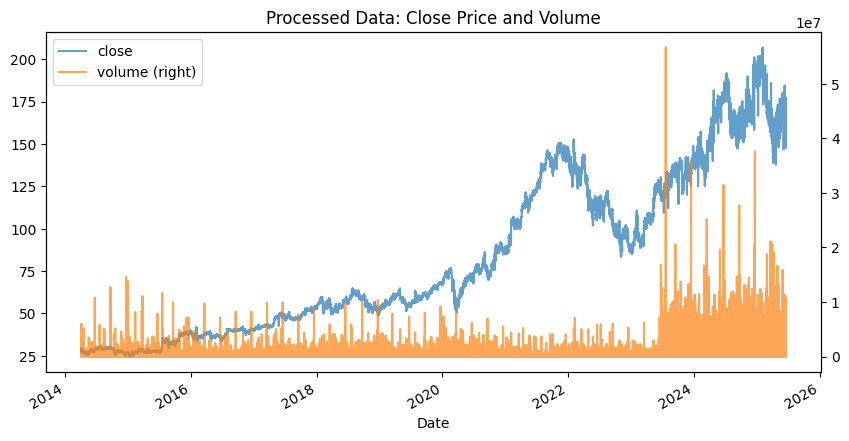

open      high       low     close   volume  \
datetime                                                               
2014-04-03 10:42:00   28.6500   28.6500   28.6500   28.6500   2000.0   
2014-04-03 10:43:00   28.6500   28.6500   28.6500   28.6500   2000.0   
2014-04-03 11:04:00   28.6500   28.6500   28.6500   28.6500  11220.0   
2014-04-03 11:05:00   28.6500   28.6500   28.6500   28.6500   4620.0   
2014-04-03 11:34:00   28.5005   28.5005   28.5005   28.5005   3460.0   
...                       ...       ...       ...       ...      ...   
2025-06-18 23:55:00  173.9000  173.9445  173.8670  173.8681   3136.0   
2025-06-18 23:56:00  173.8200  173.9500  173.7900  173.9000    183.0   
2025-06-18 23:57:00  173.9500  173.9500  173.8600  173.8601    240.0   
2025-06-18 23:58:00  173.8600  173.9000  173.8600  173.8600    327.0   
2025-06-18 23:59:00  173.8700  173.8700  173.8600  173.8700    124.0   

                            ask         bid  
datetime                                     
2014-04-03 10:42:00   28.658595   28.641405  
2014-04-03 10:43:00   28.658595   28.641405  
2014-04-03 11:04:00   28.658595   28.641405  
2014-04-03 11:05:00   28.658595   28.641405  
2014-04-03 11:34:00   28.509050   28.491950  
...                         ...         ...  
2025-06-18 23:55:00  173.920300  173.815900  
2025-06-18 23:56:00  173.952200  173.847800  
2025-06-18 23:57:00  173.912300  173.807900  
2025-06-18 23:58:00  173.912200  173.807800  
2025-06-18 23:59:00  173.922200  173.817800  

[1462494 rows x 7 columns]

In [3]:
# first process of the dataframe, adding artificial bid and ask prices, and correcting possible price splits

df = trades.process_splits(folder=folder, 
                                ticker=ticker, 
                                bidasktoclose_spread=params.bidasktoclose_spread,
                                vol_fact=1)

df

In [4]:
global_ref  = trades.compute_global_ref_profit(df = df)
global_ref # reference median used to scale the signal

1.158999999999999

In [5]:

def process_single_day(day_str, buy_threshold): 
    # Processes one calendar day, called by the function 'saveDF_checkDAY'
    print(f"\n=== Processing trading day {day_str} ===")
    day_dt = pd.to_datetime(day_str)
    day_df = df.loc[df.index.normalize() == day_dt].copy()
    if day_df.empty:
        print(" no data; skipping.")
        return

    try:
        print(" Step A: smoothing & DST adjust …")
        day_df_prep = trades.prepare_interpolate_data( 
            df=day_df,
            regular_start_shifted=params.regular_start_shifted,
            regular_start=params.regular_start,
            regular_end=params.regular_end
        )
    except ValueError as ve:
        if "window 0" in str(ve):
            print(" warning: smoothing window=0; skipping smoothing.")
        else:
            raise
            
    print("\n Step B: running trading pipeline on selected date …")
    result = trades.run_trading_pipeline(day_df_prep, 
                                         col_signal='signal_smooth',
                                         col_action='signal_action',
                                         ref_profit=global_ref,
                                         day_to_check=day_str)
    
    if result is None:
        print(" no trades found; skipping.")
        return

    df_day, trades_day, perf_day = result
    plots.plot_trades(
        df=df_day,
        col_signal1='signal_raw',
        col_signal2='signal_smooth',
        col_action='signal_action',
        trades=trades_day,
        buy_threshold=buy_threshold,
        performance_stats=perf_day
    )

    print(f"\n=== Performance for {day_dt} ===")
    for k, v in perf_day.items():
        print(f"{k}: {v}")

    return df_day, perf_day



In [6]:
def saveDF_checkDAY(
    df,
    ticker,
    min_prof_thr,
    max_down_prop,
    gain_tightening_factor,
    smooth_win_sig,
    pre_entry_decay,
    buy_threshold,
    trailing_stop_thresh,
    merging_retracement_thr,
    merging_time_gap_thr,
    keep_cols=None,
    date_to_check=params.date_to_check
):
    """
    Modes:
      • Month ('YYYY-MM')   → process each day, then summary  
      • Day   ('YYYY-MM-DD')→ process that day only  
      • None  → full‐run: smooth ALL, pipeline, merge+interpolate w/ progress, save CSV  
    """
    if keep_cols is None:
        keep_cols = [
            "open","high","low","close","volume", "bid","ask",
            "StrategyEarning","EarningDiff", "signal_raw", "signal_smooth", "signal_action"
        ]

    if date_to_check:
        if len(date_to_check) == 7:
            # -------------------------------------------------------------------------
            # # Month mode: 'YYYY-MM'
            # -------------------------------------------------------------------------
            print(f"\nMonth mode: processing {date_to_check}")

            # 1) collect all days in this month
            days = (
                df.loc[df.index.strftime("%Y-%m") == date_to_check]
                  .index.normalize()
                  .unique()
            )

            performance_list = []
            daily_frames     = []
            
            for d in sorted(days.astype(str)):
                res = process_single_day(d, buy_threshold)
                if res is None:
                    continue
    
                df_day, perf_day = res
                daily_frames.append(df_day)       # collect the day’s DF
                performance_list.append(perf_day) # collect its stats
    
            if not daily_frames:
                print("No valid days in this month.")
                return
    
            # build the month‐DF from exactly those df_day’s
            df_month = pd.concat(daily_frames).sort_index()
            # print monthly performance summary
            monthly_summary = plots.aggregate_performance(performance_list, df_month)
            pprint(monthly_summary)

            return df_month
            
        else:
            # -------------------------------------------------------------------------
            # Single-day mode: 'YYYY-MM-DD'
            # -------------------------------------------------------------------------
            return process_single_day(date_to_check, buy_threshold)

    # -------------------------------------------------------------------------
    # Full mode: Processing all days and saving dataframe
    # -------------------------------------------------------------------------
    print(f"\nFull-run mode")
        
    print(" Step A: smoothing & DST adjust …")
    df_prep = trades.prepare_interpolate_data(
        df=df,
        regular_start_shifted=params.regular_start_shifted,
        regular_start=params.regular_start,
        regular_end=params.regular_end
    )
      
    print("\n Step B: running trading pipeline on full dataset …")
    full_sim_results = trades.run_trading_pipeline( 
        df_prep,
        col_signal='signal_smooth',
        col_action='signal_action',
        ref_profit=global_ref,
        day_to_check=None
    )

    print("\n Step C: merging, concatenating all days, and calculating test performances …")
    daily_frames    = [res[0][keep_cols] for res in full_sim_results.values()]
    df_all          = pd.concat(daily_frames).sort_index()
    performance_all = [res[2] for res in full_sim_results.values()]
    all_summary = plots.aggregate_performance(performance_all, df_all)
    days_all = df_all.index.normalize().unique()
    pprint(all_summary)

    # prepare the performances summary just for the test days
    cutoff   = int(len(days_all) * (params.train_prop + params.val_prop))
    test_days = days_all[cutoff:][1:]   # to use the same test days as in the model test prediction
    df_test = df_all[ df_all.index.normalize().isin(test_days) ]
    performance_test = [perf
                        for day, (_,_,perf) in full_sim_results.items()
                        if pd.Timestamp(day).normalize() in test_days]
    test_summary = plots.aggregate_performance(performance_test, df_test)
    pprint(test_summary)
    

    print("\n Step D: saving CSV …")
    out_path = f"dfs training/{ticker}_ready.csv"
    df_all.to_csv(out_path)
    print(f"Saved to {out_path} at {datetime.now():%H:%M:%S}")

    return df_all




Month mode: processing 2020-04

=== Processing trading day 2020-04-01 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


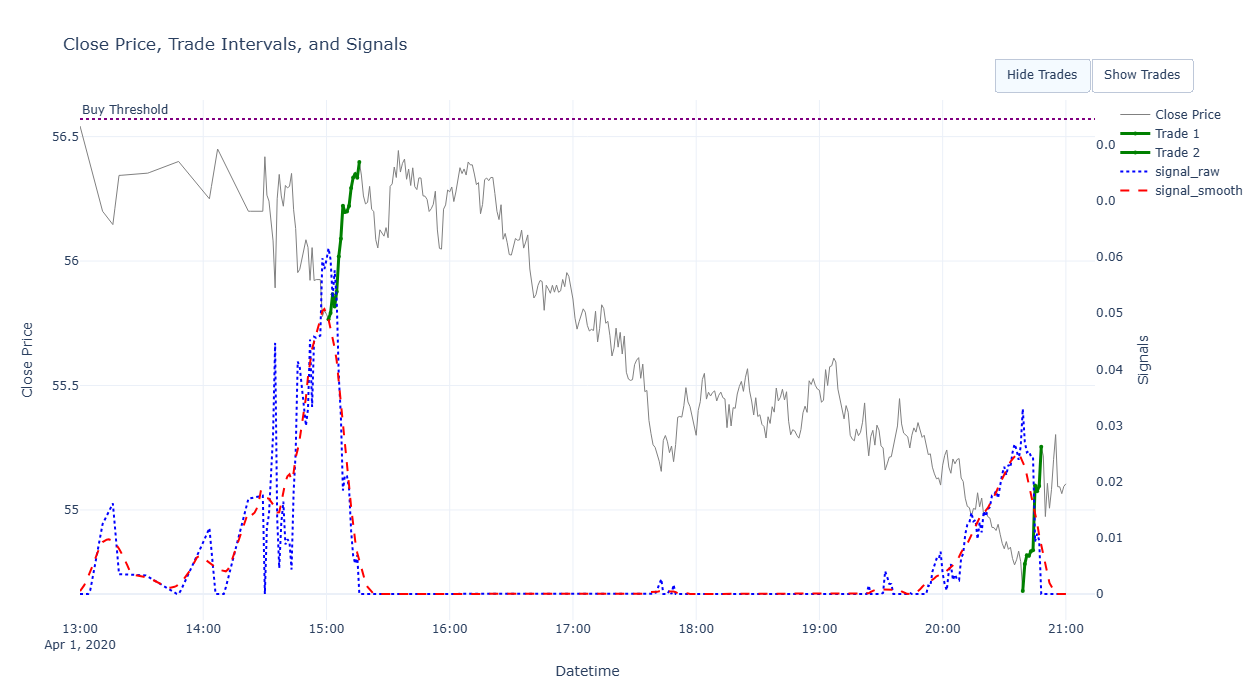


=== Performance for 2020-04-01 00:00:00 ===
Strategy Return ($): 0.0
Buy & Hold Return ($): -1.357
Trades Returns ($): []

=== Processing trading day 2020-04-02 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


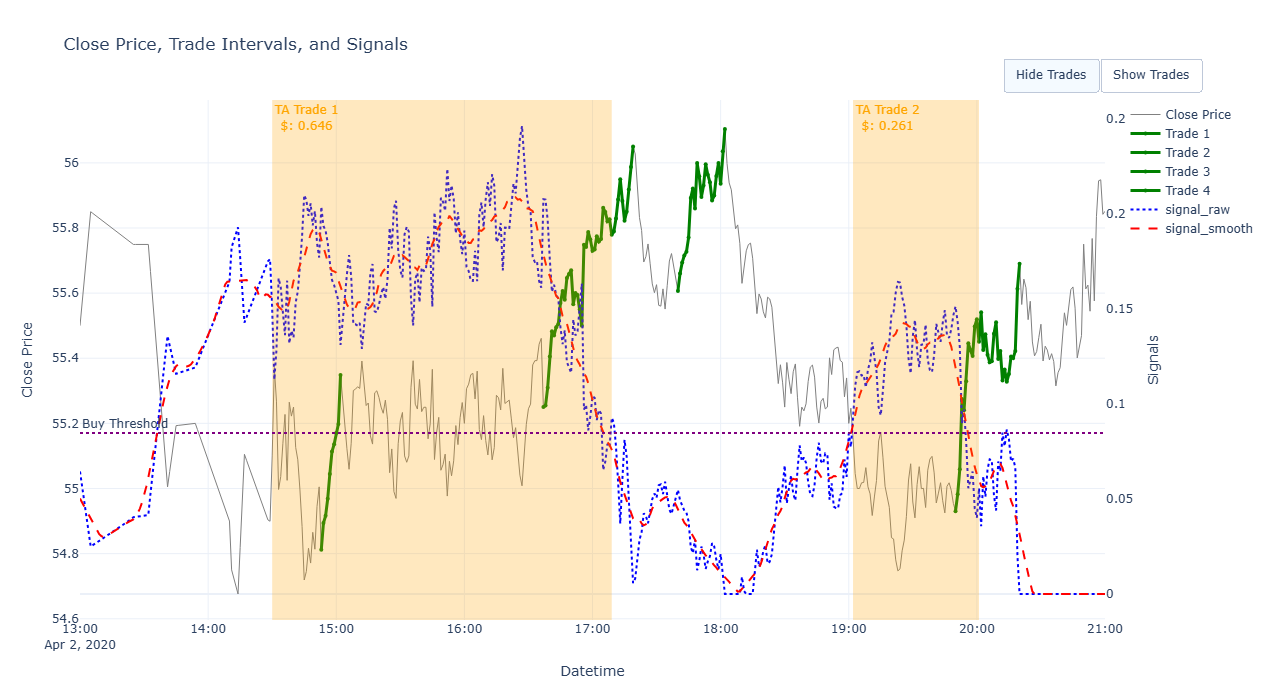


=== Performance for 2020-04-02 00:00:00 ===
Strategy Return ($): 0.908
Buy & Hold Return ($): 0.709
Trades Returns ($): [0.646, 0.261]

=== Processing trading day 2020-04-03 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


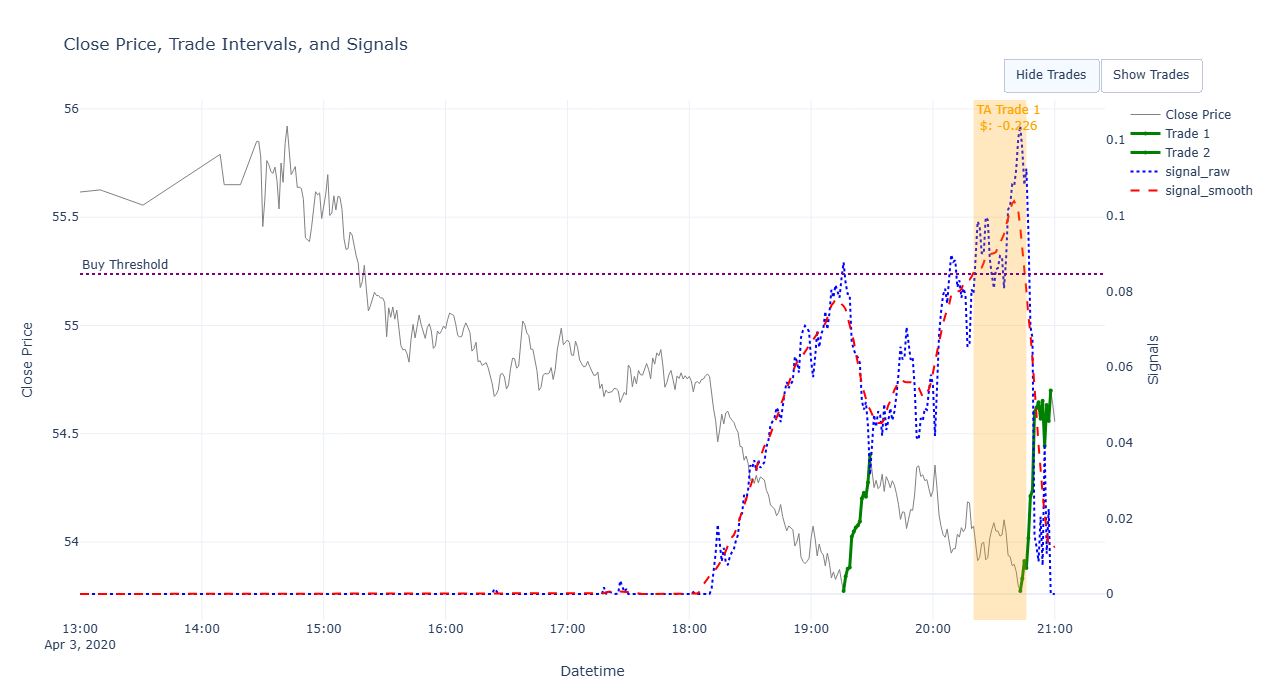


=== Performance for 2020-04-03 00:00:00 ===
Strategy Return ($): -0.226
Buy & Hold Return ($): -0.855
Trades Returns ($): [-0.226]

=== Processing trading day 2020-04-06 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


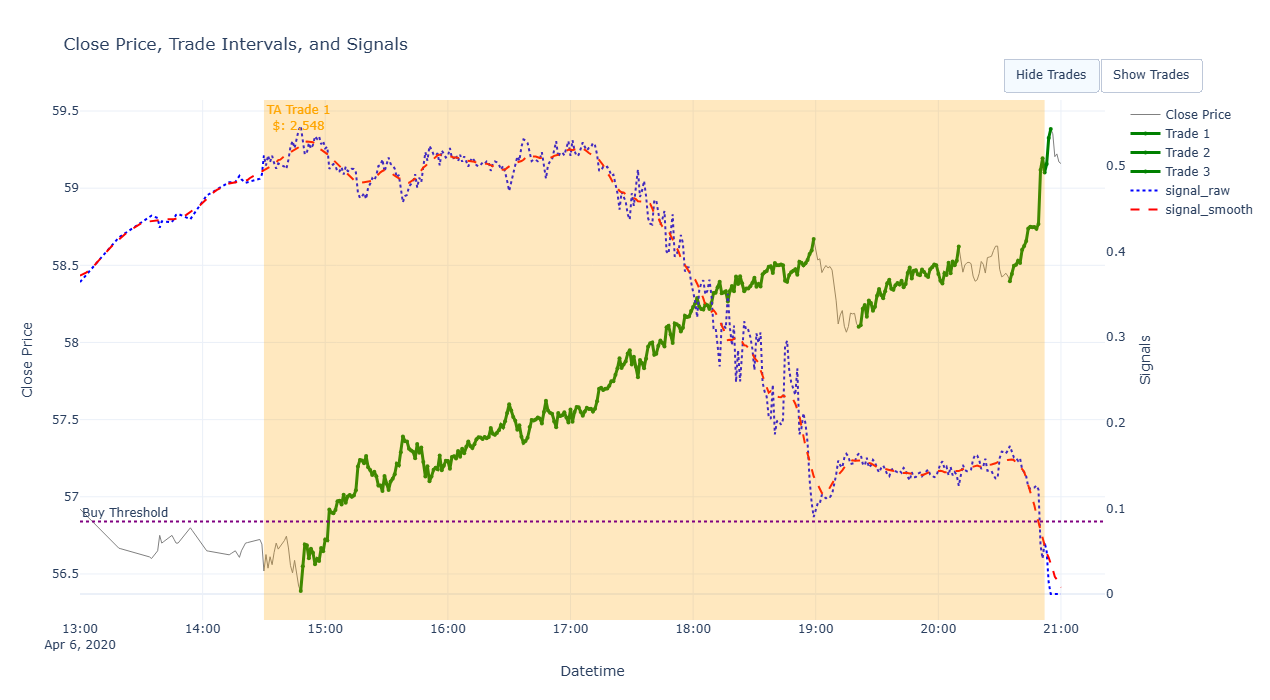


=== Performance for 2020-04-06 00:00:00 ===
Strategy Return ($): 2.548
Buy & Hold Return ($): 2.616
Trades Returns ($): [2.548]

=== Processing trading day 2020-04-07 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


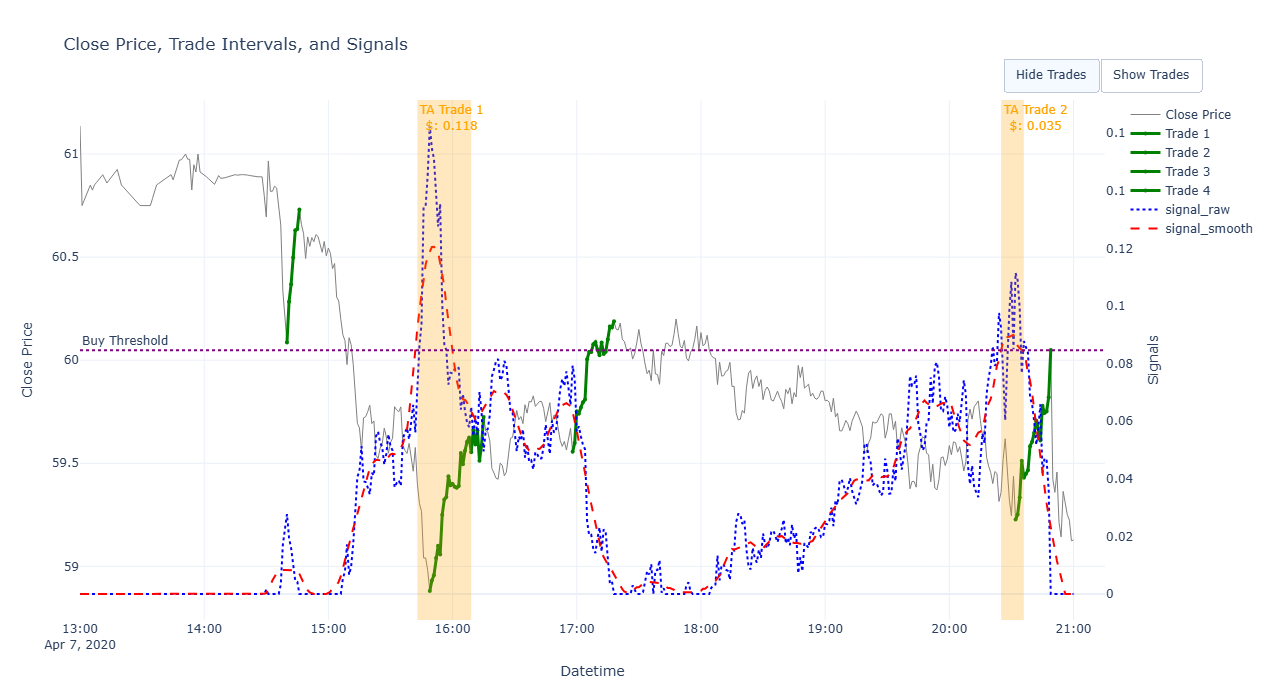


=== Performance for 2020-04-07 00:00:00 ===
Strategy Return ($): 0.153
Buy & Hold Return ($): -1.607
Trades Returns ($): [0.118, 0.035]

=== Processing trading day 2020-04-08 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


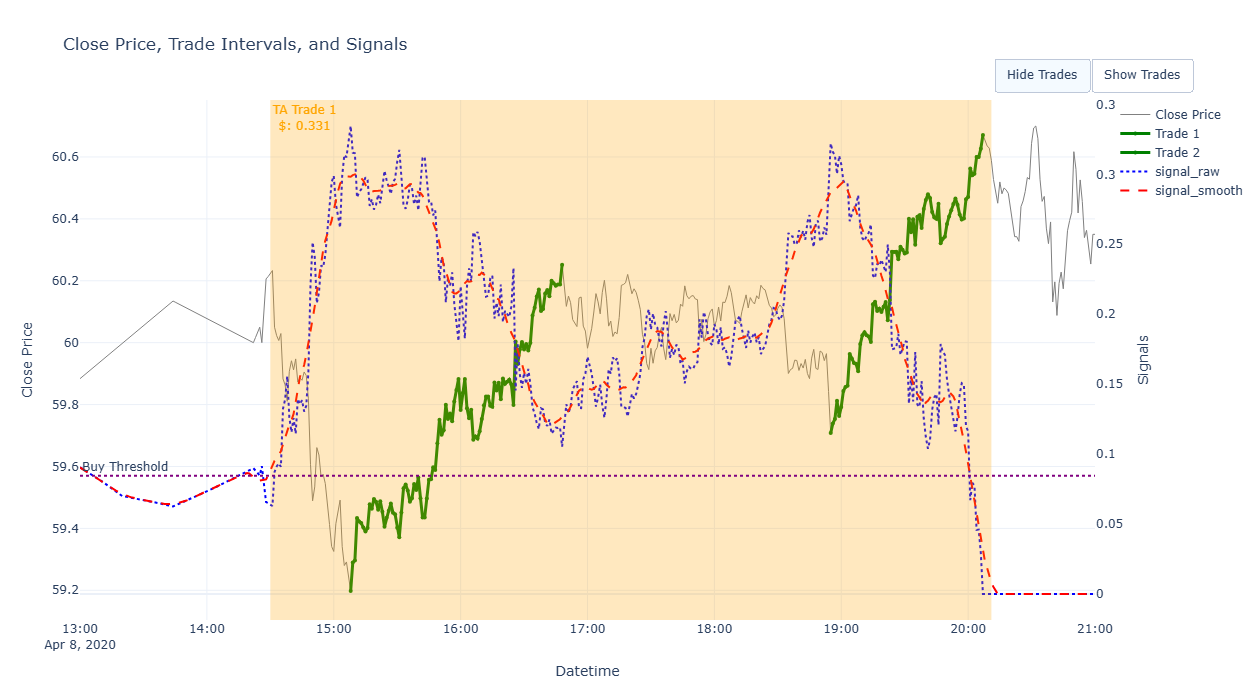


=== Performance for 2020-04-08 00:00:00 ===
Strategy Return ($): 0.331
Buy & Hold Return ($): 0.092
Trades Returns ($): [0.331]

=== Processing trading day 2020-04-09 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


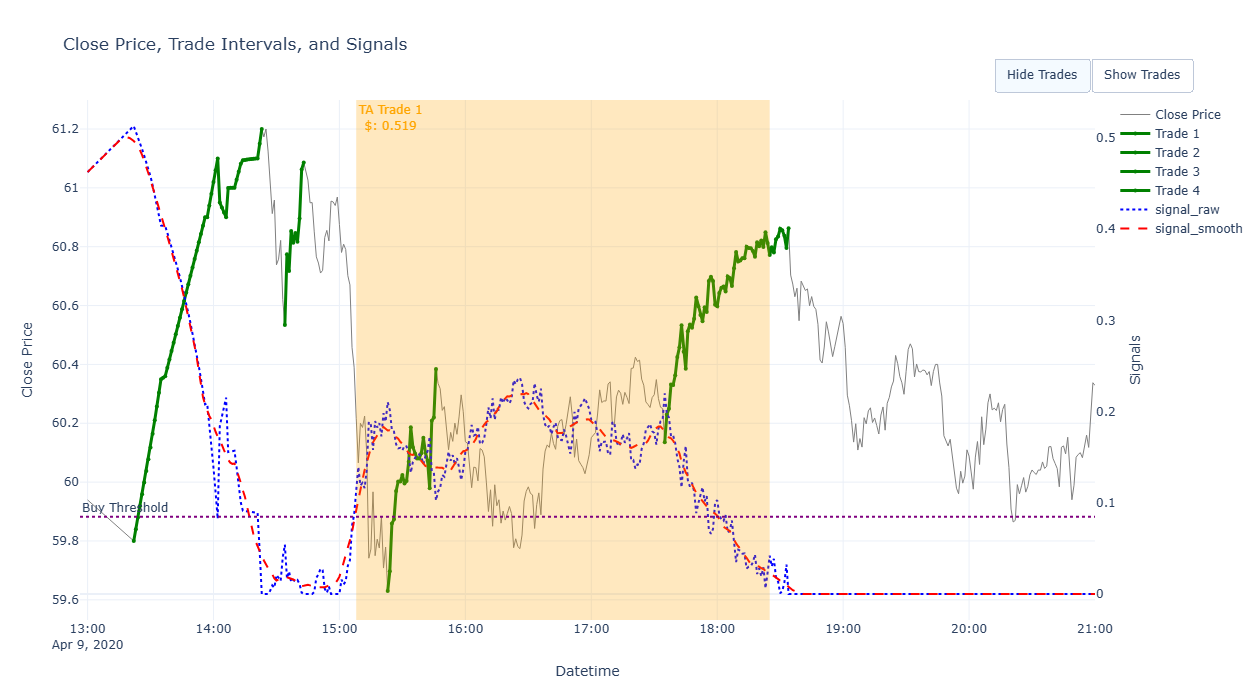


=== Performance for 2020-04-09 00:00:00 ===
Strategy Return ($): 0.519
Buy & Hold Return ($): -0.437
Trades Returns ($): [0.519]

=== Processing trading day 2020-04-13 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


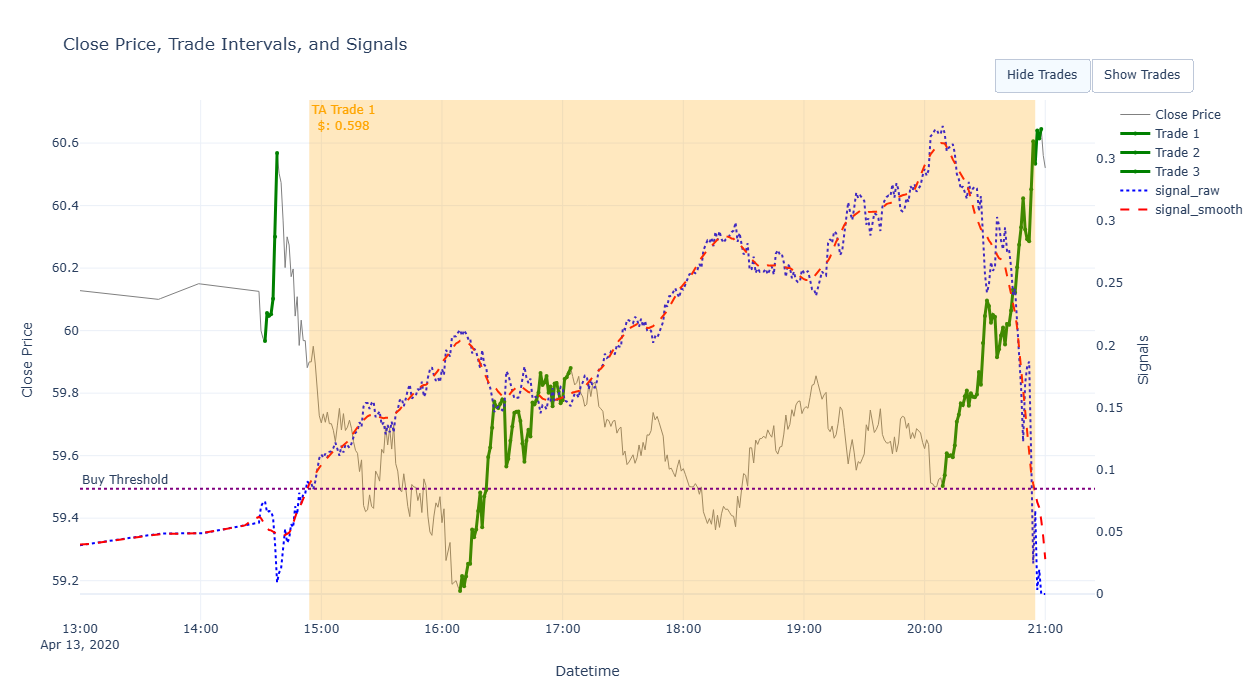


=== Performance for 2020-04-13 00:00:00 ===
Strategy Return ($): 0.598
Buy & Hold Return ($): 0.524
Trades Returns ($): [0.598]

=== Processing trading day 2020-04-14 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


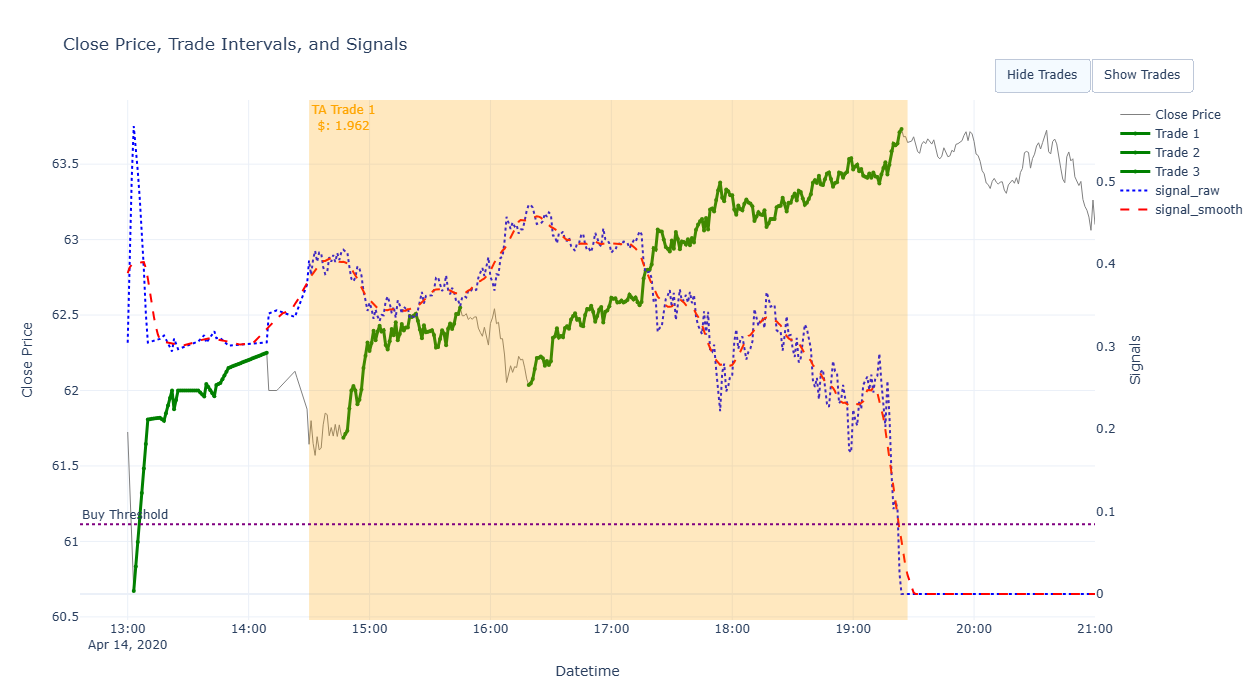


=== Performance for 2020-04-14 00:00:00 ===
Strategy Return ($): 1.962
Buy & Hold Return ($): 1.581
Trades Returns ($): [1.962]

=== Processing trading day 2020-04-15 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


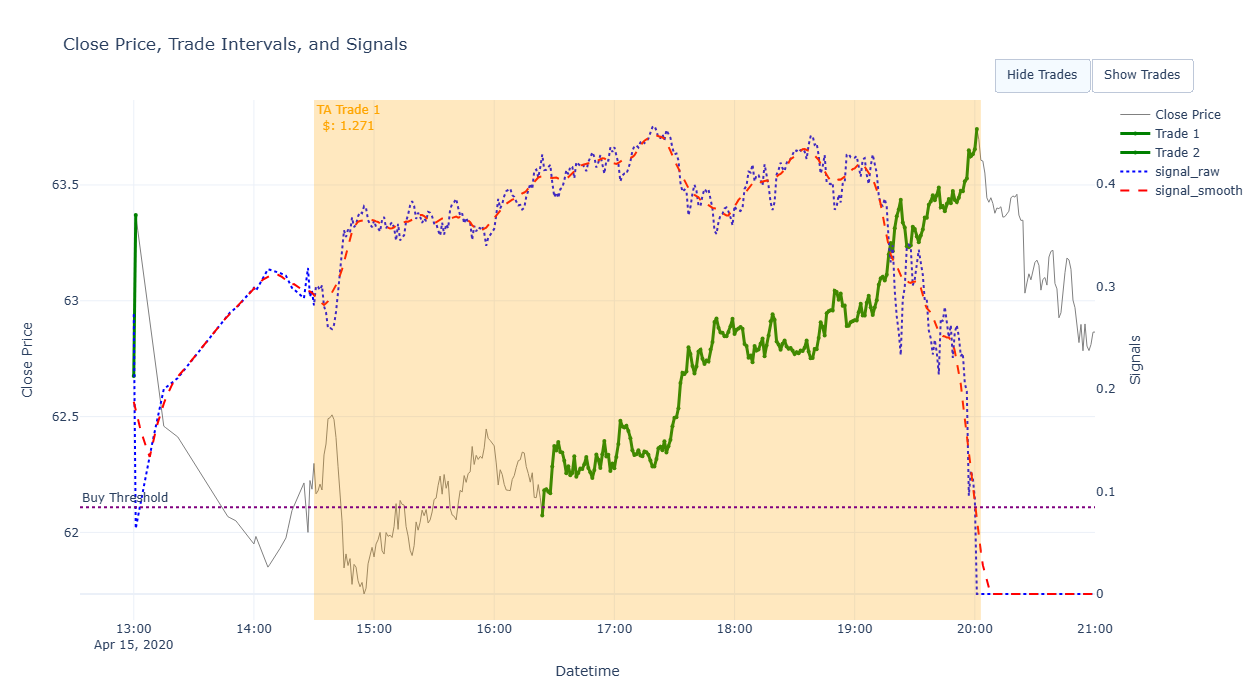


=== Performance for 2020-04-15 00:00:00 ===
Strategy Return ($): 1.271
Buy & Hold Return ($): 0.529
Trades Returns ($): [1.271]

=== Processing trading day 2020-04-16 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


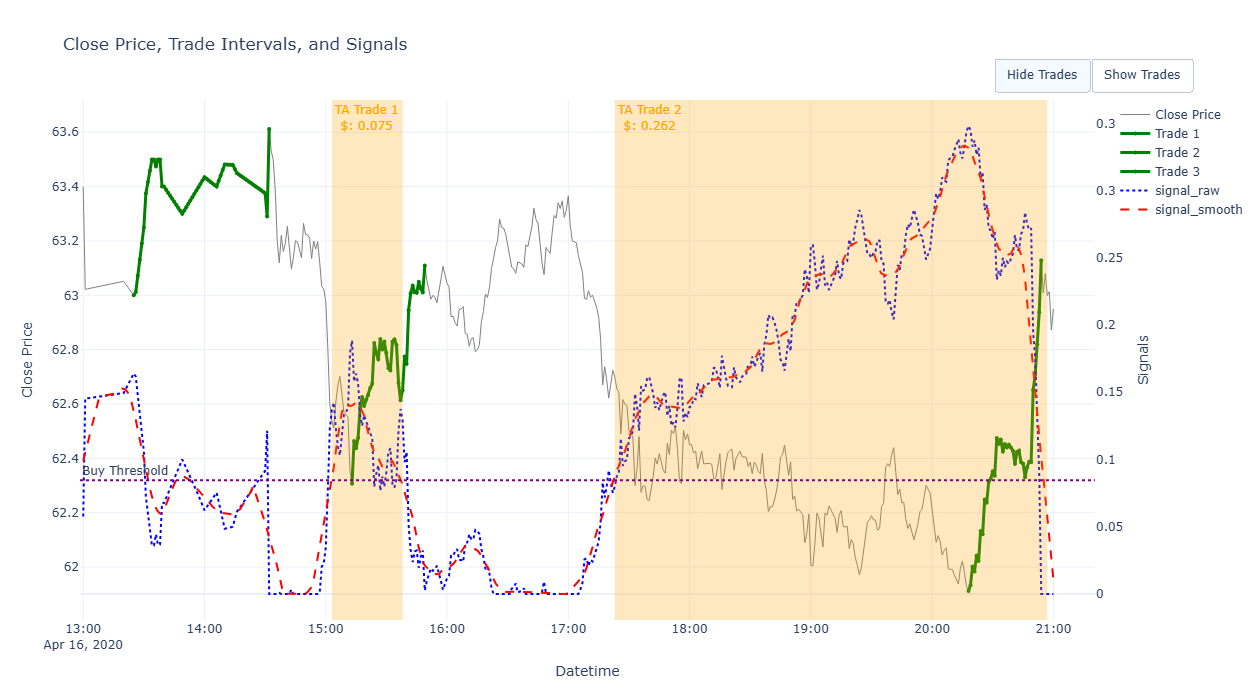


=== Performance for 2020-04-16 00:00:00 ===
Strategy Return ($): 0.337
Buy & Hold Return ($): -0.542
Trades Returns ($): [0.075, 0.262]

=== Processing trading day 2020-04-17 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


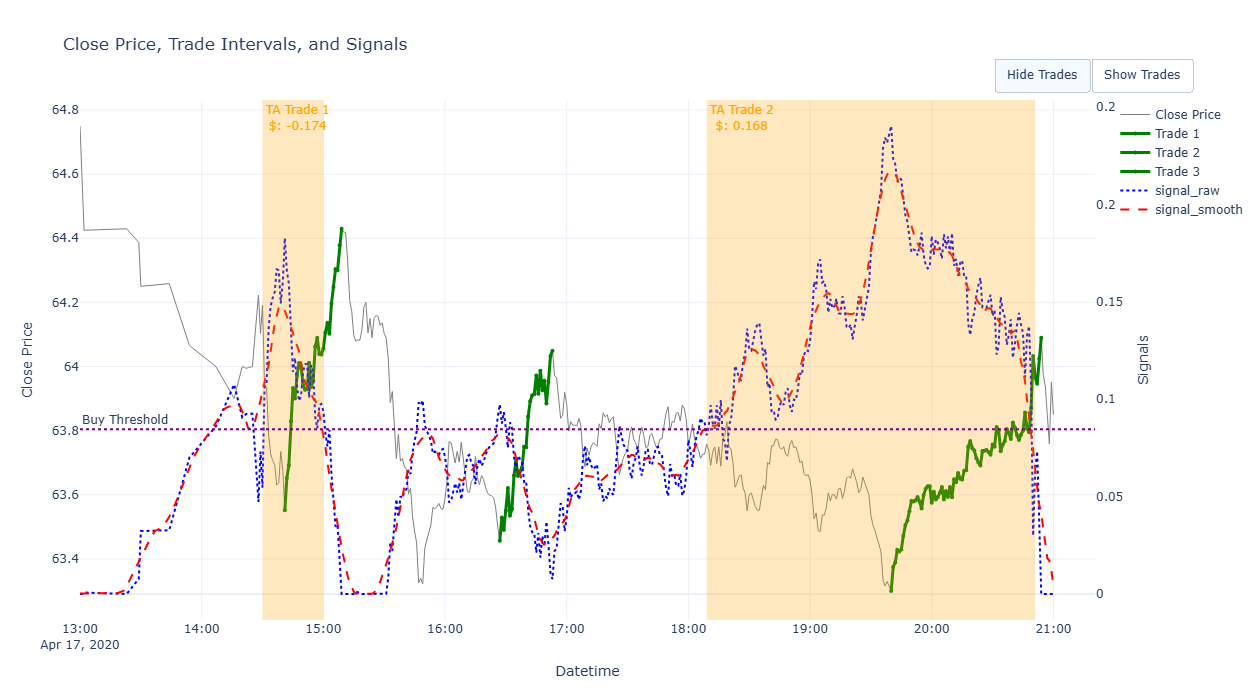


=== Performance for 2020-04-17 00:00:00 ===
Strategy Return ($): -0.005
Buy & Hold Return ($): -0.278
Trades Returns ($): [-0.174, 0.168]

=== Processing trading day 2020-04-20 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
 no trades found; skipping.

=== Processing trading day 2020-04-21 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


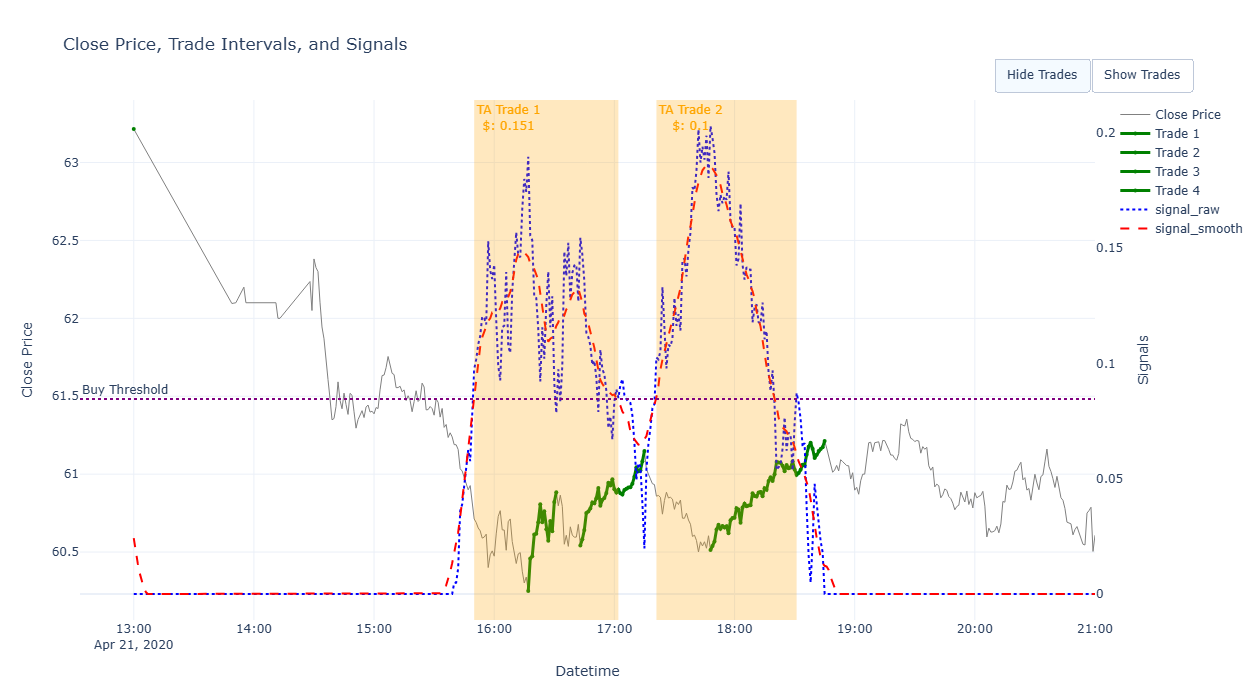


=== Performance for 2020-04-21 00:00:00 ===
Strategy Return ($): 0.251
Buy & Hold Return ($): -1.914
Trades Returns ($): [0.151, 0.1]

=== Processing trading day 2020-04-22 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


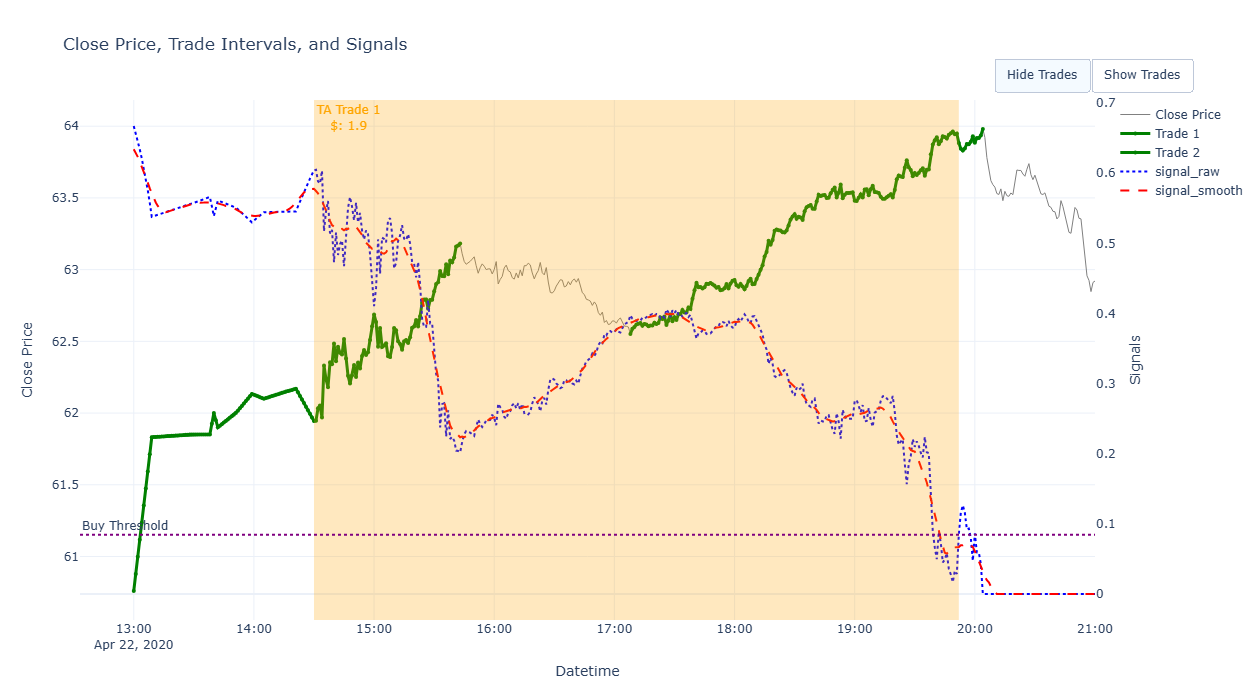


=== Performance for 2020-04-22 00:00:00 ===
Strategy Return ($): 1.9
Buy & Hold Return ($): 0.929
Trades Returns ($): [1.9]

=== Processing trading day 2020-04-23 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


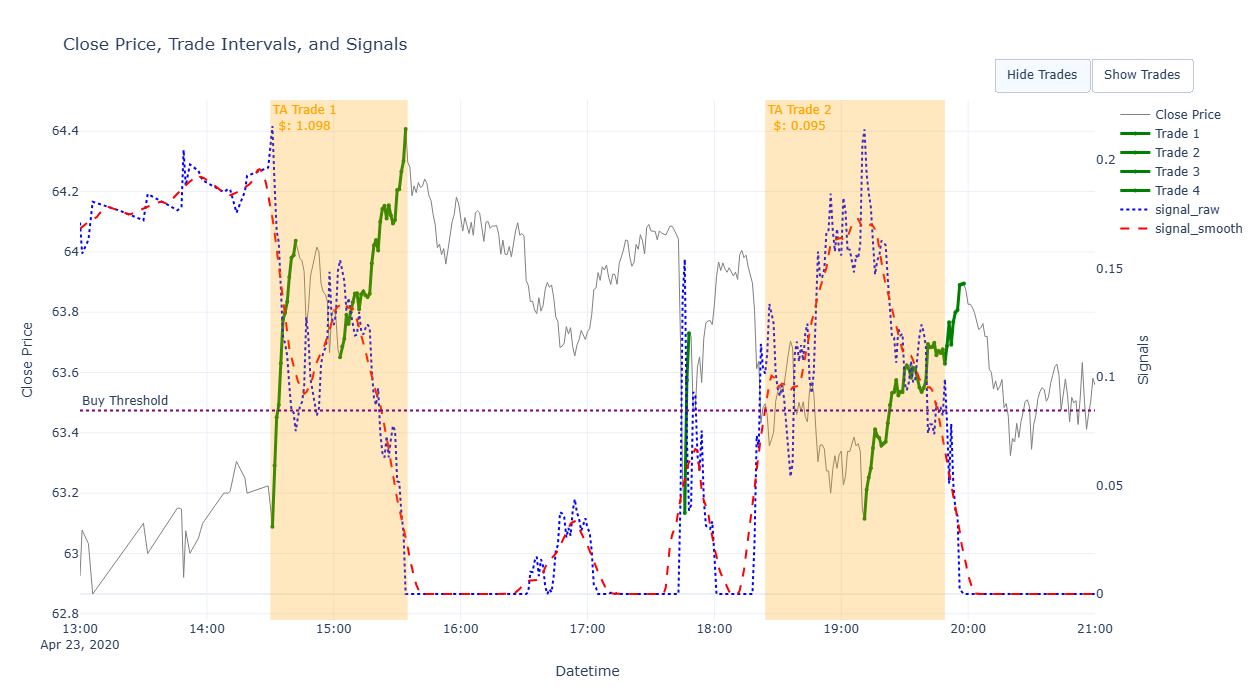


=== Performance for 2020-04-23 00:00:00 ===
Strategy Return ($): 1.193
Buy & Hold Return ($): 0.382
Trades Returns ($): [1.098, 0.095]

=== Processing trading day 2020-04-24 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


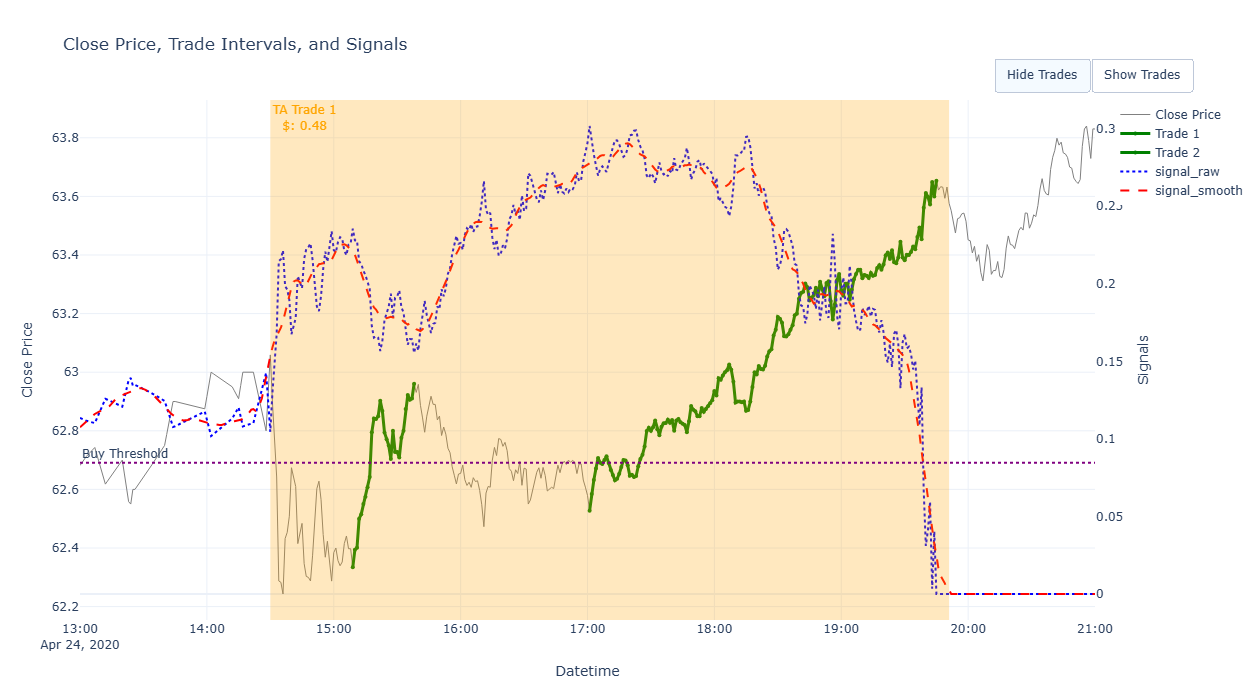


=== Performance for 2020-04-24 00:00:00 ===
Strategy Return ($): 0.48
Buy & Hold Return ($): 0.733
Trades Returns ($): [0.48]

=== Processing trading day 2020-04-27 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
 no trades found; skipping.

=== Processing trading day 2020-04-28 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …
 no trades found; skipping.

=== Processing trading day 2020-04-29 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


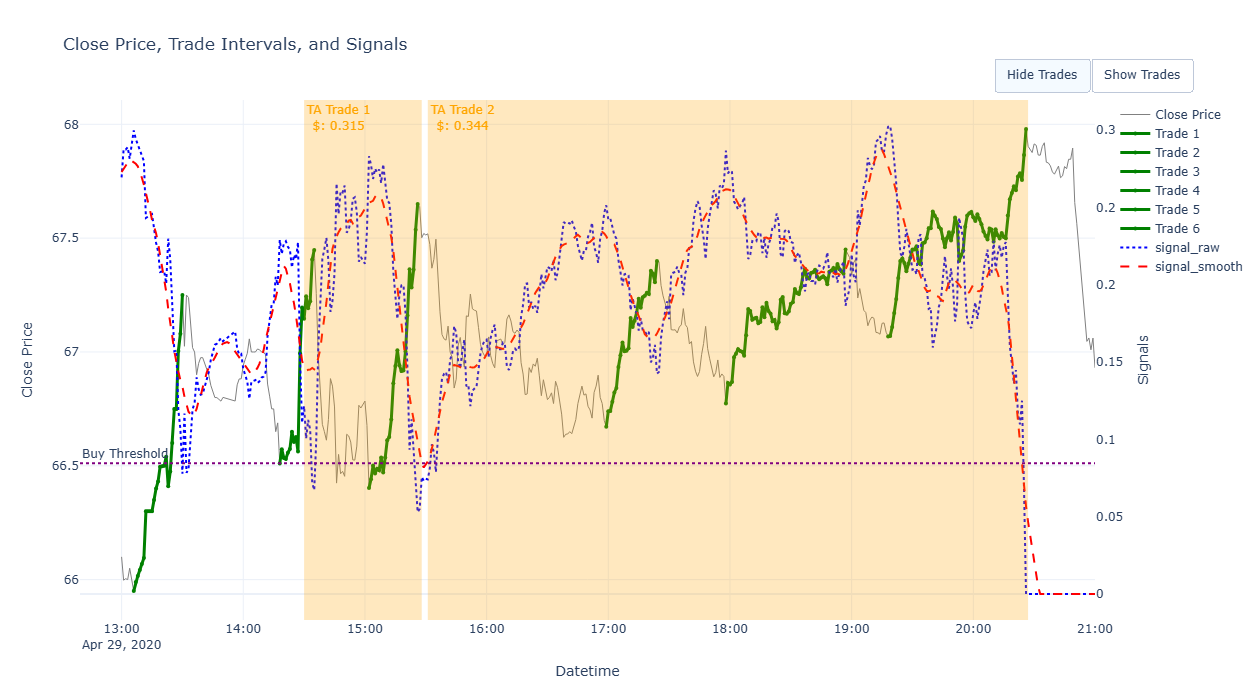


=== Performance for 2020-04-29 00:00:00 ===
Strategy Return ($): 0.659
Buy & Hold Return ($): -0.126
Trades Returns ($): [0.315, 0.344]

=== Processing trading day 2020-04-30 ===
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on selected date …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


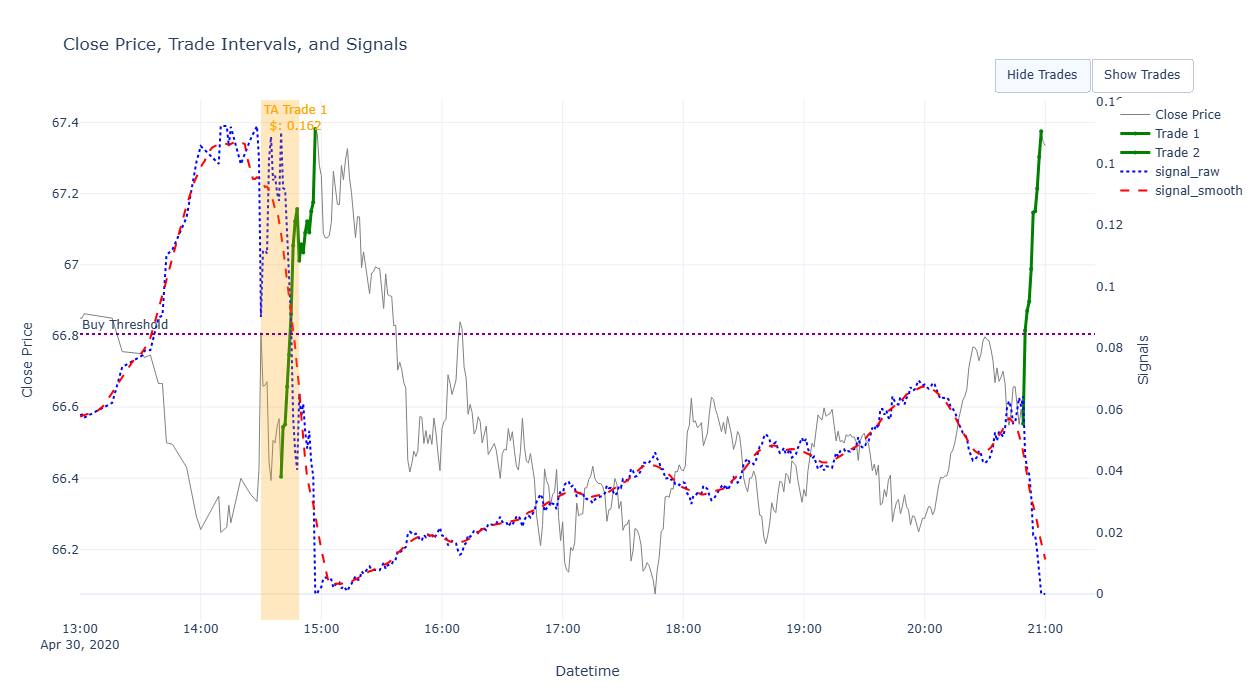


=== Performance for 2020-04-30 00:00:00 ===
Strategy Return ($): 0.162
Buy & Hold Return ($): 0.493
Trades Returns ($): [0.162]

=== Overall Summary (2020-04-01 → 2020-04-30) ===
Start date price: 2020-04-01 = 56.4359
  End date price:  2020-04-30 = 67.3148
One-time buy&hold gain: 10.879

{'Buy & Hold – each day ($)': 1.472,
 'Strategy Return ($)': 13.041,
 'Trades Returns ($)': '24 trades'}


open       high        low      close        volume  \
2020-04-01 11:30:00  56.520304  56.529059  56.518627  56.518627  1.093020e+04   
2020-04-01 11:31:00  56.521373  56.530588  56.519608  56.519608  1.096863e+04   
2020-04-01 11:32:00  56.522441  56.532118  56.520588  56.520588  1.100706e+04   
2020-04-01 11:33:00  56.523510  56.533647  56.521569  56.521569  1.104549e+04   
2020-04-01 11:34:00  56.524578  56.535176  56.522549  56.522549  1.108392e+04   
...                        ...        ...        ...        ...           ...   
2020-04-30 20:56:00  67.162500  67.231000  67.161500  67.214000  4.264400e+05   
2020-04-30 20:57:00  67.207000  67.304500  67.207000  67.303500  5.595800e+05   
2020-04-30 20:58:00  67.301000  67.387500  67.281000  67.375500  7.989400e+05   
2020-04-30 20:59:00  67.364000  67.500000  67.213000  67.343000  1.990680e+06   
2020-04-30 21:00:00  67.335000  67.335000  67.335000  67.335000  2.947700e+06   

                           ask        bid  open_orig  high_orig   low_orig  \
2020-04-01 11:30:00  56.535583  56.501672  56.520304  56.529059  56.518627   
2020-04-01 11:31:00  56.536564  56.502652  56.521373  56.530588  56.519608   
2020-04-01 11:32:00  56.537544  56.503632  56.522441  56.532118  56.520588   
2020-04-01 11:33:00  56.538525  56.504612  56.523510  56.533647  56.521569   
2020-04-01 11:34:00  56.539506  56.505592  56.524578  56.535176  56.522549   
...                        ...        ...        ...        ...        ...   
2020-04-30 20:56:00  67.234165  67.193835  67.162500  67.231000  67.161500   
2020-04-30 20:57:00  67.323690  67.283310  67.207000  67.304500  67.207000   
2020-04-30 20:58:00  67.395715  67.355285  67.301000  67.387500  67.281000   
2020-04-30 20:59:00  67.363205  67.322795  67.364000  67.500000  67.213000   
2020-04-30 21:00:00  67.355200  67.314800  67.335000  67.335000  67.335000   

                     close_orig   volume_orig   ask_orig   bid_orig  \
2020-04-01 11:30:00   56.518627  1.093020e+04  56.535583  56.501672   
2020-04-01 11:31:00   56.519608  1.096863e+04  56.536564  56.502652   
2020-04-01 11:32:00   56.520588  1.100706e+04  56.537544  56.503632   
2020-04-01 11:33:00   56.521569  1.104549e+04  56.538525  56.504612   
2020-04-01 11:34:00   56.522549  1.108392e+04  56.539506  56.505592   
...                         ...           ...        ...        ...   
2020-04-30 20:56:00   67.214000  4.264400e+05  67.234165  67.193835   
2020-04-30 20:57:00   67.303500  5.595800e+05  67.323690  67.283310   
2020-04-30 20:58:00   67.375500  7.989400e+05  67.395715  67.355285   
2020-04-30 20:59:00   67.343000  1.990680e+06  67.363205  67.322795   
2020-04-30 21:00:00   67.335000  2.947700e+06  67.355200  67.314800   

                     signal_raw  signal_smooth  signal_action  Position  \
2020-04-01 11:30:00    0.000000       0.000000              0         0   
2020-04-01 11:31:00    0.000000       0.000000              0         0   
2020-04-01 11:32:00    0.000000       0.000000              0         0   
2020-04-01 11:33:00    0.000000       0.000000              0         0   
2020-04-01 11:34:00    0.000000       0.000000              0         0   
...                         ...            ...            ...       ...   
2020-04-30 20:56:00    0.013722       0.023232              0         0   
2020-04-30 20:57:00    0.006192       0.019500              0         0   
2020-04-30 20:58:00    0.000000       0.016963              0         0   
2020-04-30 20:59:00    0.000000       0.014313              0         0   
2020-04-30 21:00:00    0.000000       0.011232              0         0   

                      Cash  NetValue    Action  TradedAmount  BuyHoldEarning  \
2020-04-01 11:30:00  0.000     0.000  No trade             0           0.000   
2020-04-01 11:31:00  0.000     0.000  No trade             0           0.000   
2020-04-01 11:32:00  0.000     0.000  No trade             0           0.000   
2020-04-01 11:33:00  0.000     0.000  No t

In [7]:
df_fin = saveDF_checkDAY(
                        df=df,
                        ticker=params.ticker,
                        min_prof_thr=params.min_prof_thr_tick, 
                        max_down_prop=params.max_down_prop_tick, 
                        gain_tightening_factor=params.gain_tightening_factor_tick,
                        smooth_win_sig=params.smooth_win_sig_tick, 
                        pre_entry_decay=params.pre_entry_decay_tick, 
                        buy_threshold=params.buy_threshold_tick, 
                        trailing_stop_thresh=params.trailing_stop_thresh_tick,
                        merging_retracement_thr=params.merging_retracement_thr_tick, 
                        merging_time_gap_thr=params.merging_time_gap_thr_tick,
                        date_to_check=params.date_to_check
                        )

df_fin


In [8]:
if date_to_check == None:
    
    # 1) Ensure the index is datetime
    df_fin.index = pd.to_datetime(df_fin.index)
    
    # 2) Filter to that month
    mask_month = df_fin.index.strftime("%Y-%m") == month_to_plot
    df_month  = df_fin.loc[mask_month]
    
    # 3) Group by calendar day
    groups = df_month.groupby(df_month.index.normalize(), sort=True)
    
    # 4) Loop over each day and make a dual-axis plot
    for day_date, df_day in groups:
        day_str = day_date.strftime("%Y-%m-%d")
        if df_day.empty:
            continue
    
        fig, ax1 = plt.subplots(figsize=(10, 4))
    
        # Plot signal_smooth & signal_raw on the left y-axis
        ax1.plot(
            df_day.index, df_day["signal_smooth"],
            color="tab:blue", lw=1.5, label="signal_smooth"
        )
        ax1.plot(
            df_day.index, df_day["signal_raw"],
            color="tab:red",  lw=1.5, label="signal_raw"
        )
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Signal Value")
        ax1.tick_params(axis="y", labelcolor="black")
    
        # Plot close price on the right y-axis
        ax2 = ax1.twinx()
        ax2.plot(
            df_day.index, df_day["close"],
            color="tab:green", lw=1.0, label="close"
        )
        ax2.set_ylabel("Close Price", color="tab:green")
        ax2.tick_params(axis="y", labelcolor="tab:green")
    
        # Combine legends from both axes
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
    
        plt.title(f"Signals & Close Price on {day_str}")
        ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%H:%M"))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
